Name: Subrat Kishore Dutta  
Matrikelnummer: 7028082
Email:   subratkishoredutta1234@gmail.com, sudu00001@stud-uni.saarland.de
   
Name:   Prathvish Mithare
Matrikelnummer:   7028692
Email: prmi00001@stud-uni.saarland.de

### Note: This assignment will extensively refer to coding exercise in assignment 4.

## 6.2.a Building your own Neural-Network

Import numpy, which is really all we need to create our own NN.

In [1]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
# Remember to Fix your seeds for pytorch and numpy

Recall that our simple neural network consisted of two layers. We also added an `activation` function as a non-linearity to the output of our intermediate layer. Given an input $\mathbf{x} \in \mathbb{R}^n $ we have

$ \mathbf{h} = f^{(1)}(\mathbf{x}; \mathbf{W},c) = activation\_fn(\mathbf{W}^\mathsf{T} \mathbf{x} + c) $ 

$ \mathbf{y} = f^{(2)}(\mathbf{h}; \mathbf{w},b) = \text{$ softmax $}( \mathbf{w}^\mathsf{T} \mathbf{h} + b) $

In this exercise you will create your own network and are free to implement it with your own design choices. However, we will do it in a way that allows you to specify the depth of network, i.e. we extend our network such that there isn't just one $\mathbf{h}$ intermediate layers, but rather $n$ of them $\mathbf{h}_{i}$ with $i \in \{1,..., n\}$

**NOTE**: You are not allowed to use any built-in functions to calculate Leaky_ReLU, Softmax or the forward/backward pass directly.

**NOTE 2**: Remember to include the non-linearity at every layer. Remember to also add the bias to every layer. Finally, remember to apply the softmax in the output layer.

## ToDo: Rewrite the Leaky_ReLu and Softmax function as Class and implement a function in each of them to calculate gradients (1 point)
Remember that in PyTorch, these are implemented as classes so we also want to have them as classes.

In [416]:
class leaky_relu:
    """
    Recall your implementation of relu function in assignment 4 and try to implement
    Leaky_ReLu similarily, but as a class with a function to calculate gradient
    """
    # TODO: Implement
    def __init__(self,alpha=1e-2):
        self.alpha=alpha
    
    def forward(self,x):
        return (np.maximum(0,x)+self.alpha*np.minimum(0,x))
    
    def grad(self,xs):
        return [1 if x>0 else self.alpha for x in xs]

In [417]:
class softmax:
    """
    Recall your implementation of softmax function in assignment 4 and try to implement
    softmax similarily, but as a class with a function to calculate gradient
    """
    # TODO: Implement
    def forward(self,x):
        s=np.exp(x) / (np.exp(x).sum())
        return s
    def grad(self,x):
        s=self.forward(x)
        dev=np.diag(s)
        for i in range(len(x)):
            for j in range(len(x)):
                if i!=j:
                    dev[i][j]=-s[i]*s[j]
                elif i==j:
                    dev[i][j]= s[i] * (1-s[i])
        return dev

In [418]:
s=softmax()
t=s.forward([[1,2],[1,2]])
print(t)
d=np.diag(t)
#print(d)
s.grad([1,2])

[[0.13447071 0.36552929]
 [0.13447071 0.36552929]]


array([[ 0.19661193, -0.19661193],
       [-0.19661193,  0.19661193]])

## ToDo: Calculate the gradient using your implemented functions in their respective classes and validate by manually calculating gradients using a toy value. (1 point)

In [409]:
## Solution
np.random.seed(1)
X=np.random.randn(2)
print('X:\n',X)
##leaky relu:
lr=leaky_relu()
y=lr.forward(X)
print("leaky relu output:\n",y)
gy=lr.grad(y)
print("leaky relu gradient:\n",gy)

##softmax:
s=softmax()
y=s.forward(X)
print("softmax output:\n",y)
gy=s.grad(y)
print("softmax gradient:\n",gy)

X:
 [ 1.62434536 -0.61175641]
leaky relu output:
 [ 1.62434536 -0.00611756]
leaky relu gradient:
 [1, 0.01]
softmax output:
 [0.90344494 0.09655506]
softmax gradient:
 [[ 0.21334829 -0.21334829]
 [-0.21334829  0.21334829]]


## ToDo: Rewrite the code from Assignment 4 to include backpropagation in your class without using pytorch. Remember to use your Leaky_ReLu class here as activation function. (1.5 points)
#### Feel free to refer to your solutions from Assignment 4.

In [256]:
class FFNetwork:
    """
    Class representing the feed-forward neural network
    """
    def __init__(self, input_dim: int, hidden_dim: int,
                 output_dim: int, hidden_size: int):
        self.weight=[]
        self.weight.append(np.random.randn(input_dim,hidden_dim))#+1 for the bias
        for i in range(hidden_size):
            self.weight.append(np.random.randn(hidden_dim,hidden_dim)) #+1 fot the bias
        self.weight.append(np.random.randn(hidden_dim,output_dim))
        
    def forward(self,x):
        
        
        z=[]
        a=[]
        res = np.array(x)
        #res=np.hstack((res,np.ones((res.shape[0],1))))
        res=np.matmul(res,self.weight[0])
        z.append(res)
        res=lr.forward(res)
        a.append(res)
        for j in range(1,len(self.weight)):
            #res=np.hstack((res,np.ones((res.shape[0],1))))
            res=np.matmul(res,self.weight[j])
            z.append(res)
            res=lr.forward(res)
            a.append(res)
        #res=np.hstack((res,np.ones((res.shape[0],1))))
        res=np.matmul(res,self.weight[-1])
        z.append(res)
        res=s.forward(res)
        a.append(res)
        return z,a
      
    def backwards(self,y,z,a):
        dw=[]
        y=np.array(y)
        delta = [None] * len(self.weight)  
        # insert the last layer error
        n = len(y)
        loss=0
        for i in range(n):
            loss+=-np.sum(np.log(a[-1][y.argmax(axis=1)]))
        delta[-1] = (y-a[-1])*(s.grad(z[-1]))
        for i in reversed(range(len(delta)-1)):
            #print('lr:',lr.grad(z[i]))
            delta[i] = np.array(lr.grad(z[i]))*(self.weight[i+1].T.dot(delta[i+1]))
        
        dw = [a[i]*d for i,d in enumerate(delta)]
        return loss,dw
    
    def train(self,xs,ys,lr=0.01,epochs=5):
        for i in range(epochs):
            tloss=0
            for x,y in zip(xs,ys):#stochastic gradient descent setup
                z,a = self.forward(x)
                loss,dw=self.backwards([y],z,a)
                tloss+=loss
                ws=[]
                for w,D in zip(self.weight,dw):
                    w+=-lr*D
                    ws.append(w)
                self.weight=ws
            print(f'epoch:{i+1}/{epochs} loss:{tloss/len(xs):.4f}')

In [271]:
x =[[1.,1.],[0.,0.],[1.,0.],[0.,1.]]
y = [[1,0],[1,0],[0,1],[0,1]]
network = FFNetwork(2,2,2, 1)
z,a = network.forward(x)
network.train(x,y,0.5,10)

epoch:1/10 loss:0.7480
epoch:2/10 loss:0.7239
epoch:3/10 loss:0.7134
epoch:4/10 loss:0.7078
epoch:5/10 loss:0.7044
epoch:6/10 loss:0.7020
epoch:7/10 loss:0.7003
epoch:8/10 loss:0.6990
epoch:9/10 loss:0.6980
epoch:10/10 loss:0.6972


In [23]:
lrs=10**torch.linspace(-4,0,100)
losses = [0,1,2,3,4,5,6,7,8,9]
lrs[losses.index(min(losses))]
lrs

tensor([1.0000e-04, 1.0975e-04, 1.2045e-04, 1.3219e-04, 1.4508e-04, 1.5923e-04,
        1.7475e-04, 1.9179e-04, 2.1049e-04, 2.3101e-04, 2.5354e-04, 2.7826e-04,
        3.0539e-04, 3.3516e-04, 3.6784e-04, 4.0370e-04, 4.4306e-04, 4.8626e-04,
        5.3367e-04, 5.8570e-04, 6.4281e-04, 7.0548e-04, 7.7426e-04, 8.4975e-04,
        9.3260e-04, 1.0235e-03, 1.1233e-03, 1.2328e-03, 1.3530e-03, 1.4850e-03,
        1.6298e-03, 1.7886e-03, 1.9630e-03, 2.1544e-03, 2.3645e-03, 2.5950e-03,
        2.8480e-03, 3.1257e-03, 3.4305e-03, 3.7649e-03, 4.1320e-03, 4.5349e-03,
        4.9770e-03, 5.4623e-03, 5.9948e-03, 6.5793e-03, 7.2208e-03, 7.9248e-03,
        8.6975e-03, 9.5455e-03, 1.0476e-02, 1.1498e-02, 1.2619e-02, 1.3849e-02,
        1.5199e-02, 1.6681e-02, 1.8307e-02, 2.0092e-02, 2.2051e-02, 2.4201e-02,
        2.6561e-02, 2.9151e-02, 3.1993e-02, 3.5112e-02, 3.8535e-02, 4.2292e-02,
        4.6416e-02, 5.0941e-02, 5.5908e-02, 6.1359e-02, 6.7342e-02, 7.3907e-02,
        8.1113e-02, 8.9022e-02, 9.7701e-

,### 6.2.b.2 Training a network for MNIST (1.5 points)

Now that we know how to train a Neural network in Pytorch. Let's start training and evaluating our model using a very standard dataset, for now let's use MNIST. Design a network from scracth using PyTorch and include the followings. Remember that we need to use forward-propagation and backprop.
- Training Loop
- Optimization 
- Evaluating Loop,

In [8]:
import torch
import torch.nn.functional as F

import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [9]:
##loading the dataset:
datatrain = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
datatest = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(len(datatrain))
print(len(datatest))

train_loader = DataLoader(datatrain,batch_size=32)
test_loader = torch.utils.data.DataLoader(datatest,batch_size=1)


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw




Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw




Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

60000
10000


In [13]:
##designing the network
class TorchFFNetwork(nn.Module):
    """
    A pytorch implementation to do classification for MNIST dataset.
    """
    def __init__(self,input_dim,hidden_dim,output_dim,hidden_size):
        super(TorchFFNetwork, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim  = hidden_dim
        self.output_dim = output_dim
        self.hidden_size = hidden_size
        self.fci = nn.Linear(self.input_dim, self.hidden_dim)
        self.fch = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fco = torch.nn.Linear(self.hidden_dim,self.output_dim)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
        
    def forward(self,x):
        o=self.fci(x)
        o=self.relu(o)
        for i in range(self.hidden_size):
            o=self.fch(o)
            o=self.relu(o)
        o=self.fco(o)
        o=self.softmax(o)
        return o

In [14]:
input_dim = 28*28
hidden_dim = 10 #number of neurons
hidden_size = 2 #number of layers
output_dim = 10
learning_rate = 0.01
epochs=10
model = TorchFFNetwork(input_dim,hidden_dim,output_dim,hidden_size)
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [15]:
##training loop and Optimisation
input_dim = 28*28
hidden_dim = 10 #number of neurons
hidden_size = 2 #number of layers
output_dim = 10
learning_rate = 0.01
epochs=10
model = TorchFFNetwork(input_dim,hidden_dim,output_dim,hidden_size)
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    tloss=0
    accuracy=[]
    temp=0
    for i,(x,ys) in enumerate(train_loader):
        acc=[]
        pred=model(x.reshape(-1, 28*28))
        loss=lossfunc(pred,ys)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss+=loss.item()
        for p,y in zip(pred,ys):
            if (p.argmax().item()==y.item()):
                acc.append(1)
            else:
                acc.append(0)
        accuracy.append(sum(acc)/len(ys))
    temp=(sum(accuracy)/(len(datatrain)/32))
    print(f'epoch:{epoch+1}/{epochs} loss:{tloss/(len(datatrain)/32):.4f} training accuracy:{temp*100:.2f}%')

epoch:1/10 loss:1.7233 training accuracy:73.77%
epoch:2/10 loss:1.6391 training accuracy:82.15%
epoch:3/10 loss:1.6572 training accuracy:80.35%
epoch:4/10 loss:1.6550 training accuracy:80.61%
epoch:5/10 loss:1.6532 training accuracy:80.76%
epoch:6/10 loss:1.6638 training accuracy:79.71%
epoch:7/10 loss:1.6634 training accuracy:79.77%
epoch:8/10 loss:1.6574 training accuracy:80.36%
epoch:9/10 loss:1.6734 training accuracy:78.77%
epoch:10/10 loss:1.6720 training accuracy:78.91%


In [523]:
# Evaluation
accuracy=0
for i,(x,y) in tqdm(enumerate(test_loader)):
    pred=model(x.reshape(-1, 28*28))
    loss=lossfunc(pred,y)
    #print('pred:',pred.argmax(axis=1).item())
    #print('y:',y.item())
    if y.item()== pred.argmax(axis=1).item():
        accuracy+=1
print("testing accuracy:",(accuracy/len(datatest))*100,'% testing loss:',(loss/len(datatest)))

10000it [00:03, 2634.38it/s]


testing accuracy: 85.68 % testing loss: tensor(0.0001, grad_fn=<DivBackward0>)


### ToDo: Implement functions for Stochastic Gradient Descent and Stochastic Gradient Descent with momentum and plot the difference on how they change the value for gradients. ( 1 + 1 (Bonus))

In [531]:
def  loss_func(theta,X,y):    
    predictions = X.dot(theta)
    cost = (1/2) * np.sum(np.square(predictions-y))
    return cost

w1:0.3641,
w2:0.2287
loss:5.050


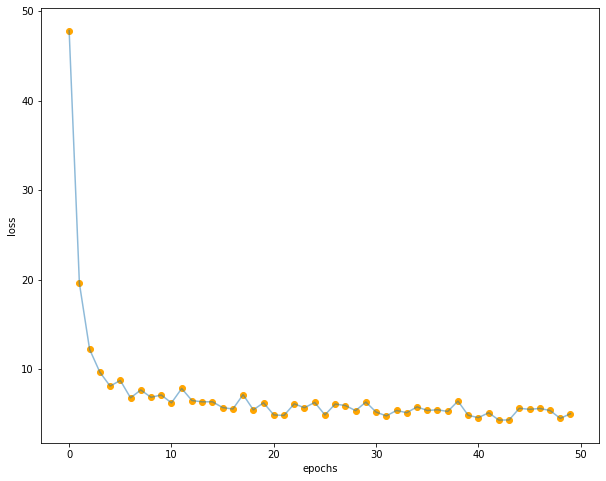

In [533]:
##stochastic gradient descent:

def SGD(X,Y,w,learning_rate=0.01,epochs=10):
    m = len(Y)
    history = np.zeros(epochs)
    for epoch in range(epochs):
        loss =0.0
        for i in range(m):
            idx=np.random.randint(0,m)
            x = X[idx].reshape(1,X.shape[1])
            y = Y[idx]
            pred = np.dot(x,w)
            loss += loss_func(w,x,y)
            w = w -(1/m)*learning_rate*( x.T.dot((pred - y)))
        history[epoch]=loss
    return w, history

lr =0.5

epochs = 50
w = np.random.randn(2)
X = np.random.rand(100)
y = np.random.rand(100)
X = np.c_[np.ones((len(X),1)),X]#for the bias term
w,history = SGD(X,y,w,lr,epochs)
print(f'w1:{w[0]:0.4f},\nw2:{w[1]:0.4f}')
print(f'loss:{history[-1]:0.3f}')
fig= plt.figure(figsize=(10,8))
plt.ylabel('loss')
plt.xlabel('epochs')
plt.plot(range(epochs),history,alpha=0.5)
plt.scatter(range(epochs),history,c='orange')

In [534]:
## minibatch gradient descent
def minibatch_gradient_descent(X,Y,w,learning_rate=0.01,epochs=10,bs =20):
    m = len(Y)
    history = np.zeros(epochs)
    nb = int(m/bs)
    for epoch in range(epochs):
        loss=0.0
        idx = np.random.permutation(m)
        X = X[idx]
        Y = Y[idx]
        for i in range(0,m,bs):
            x = X[i:i+bs]
            y = Y[i:i+bs]    
            x = np.c_[np.ones(len(x)),x]   
            pred= np.dot(x,w)
            w = w -(1/m)*learning_rate*( x.T.dot((pred-y)))
            loss += loss_func(w,x,y)
        history[epoch]  = loss       
    return w, history

w1:0.4891493937912226,
w2:0.019606980246557704
loss:40.335


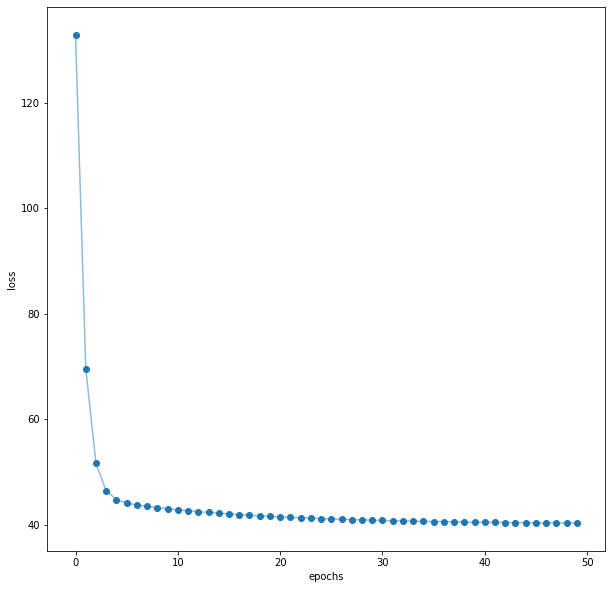

In [541]:
lr =0.5

epochs = 50
w = np.random.randn(2)
X = np.random.rand(1000)
y = np.random.rand(1000)
#w = np.random.randn(2,1)
w,history = minibatch_gradient_descent(X,y,w,lr,epochs,bs=16)
print(f'w1:{w[0]},\nw2:{w[1]}')
print(f'loss:{history[-1]:0.3f}')
fig= plt.figure(figsize=(10,10))
plt.ylabel('loss')
plt.xlabel('epochs')
plt.plot(range(epochs),history,alpha=0.5)
plt.scatter(range(epochs),history)